In [1]:
card_name = 'Cat_q2var_test'

In [ ]:
fit_real_data = False

# Import

In [2]:
import sys, os
from glob import glob
sys.path.append('../lib')
import itertools

In [3]:
import numpy as np
import uproot as ur
import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel
from histo_utilities import create_TH1D, create_TH2D, std_color_list
from cebefo_style import Set_2D_colz_graphics

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Preliminary"

donotdelete = []

Welcome to JupyROOT 6.12/07


# Create histograms file

In [4]:
file_loc = {
'mu'   : '../data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_SoftQCD_PTFilter5_0p0-evtgen_HQET2_central_PU35_10-2-3_v0/B02DstMu_candidates/out*.root',
'tau'  : '../data/cmsMC_private/BPH_Tag-B0_TauNuDmst-pD0bar-kp-t2mnn_pythia8_SoftQCD_PTFilter5_0p0-evtgen_HQET2_central_PU35_10-2-3_v0/B02DstMu_candidates/out*.root'
}
if fit_real_data:
    file_loc['data'] = '../data/cmsRD/Run2018D/B02DstMu_19*_BPH*.root'

branches = ['q2', 'Est_mu', 'M2_miss',
            'mass_MuDst', 'cos_MuDst_vtxBest'
           ]

dSet = {}
for k, fn in file_loc.iteritems():
    dSet[k] = extarct_multiple(fn, branches=branches, flag=k)
    print k, ':', dSet[k]['Est_mu'].shape[0], 'candidates'

mu : 15963 candidates
tau : 7222 candidates


In [5]:
analysis_selection = {
'mass_MuDst'      : ['<', 5.280],
'cos_MuDst_vtxBest' : ['>', 0.98]
}

binning = {
    'q2'      : [4, -2, 10.7],
    'M2_miss' : [40/2, -5, 10],
    'Est_mu'  : [30/2, 0.10, 2.500]
}

In [6]:
histo = {}
for i_q2 in range(binning['q2'][0]):
    w_q2 = (binning['q2'][2] - binning['q2'][1])/binning['q2'][0]
    q2_l = binning['q2'][1] + w_q2 * i_q2
    q2_h = binning['q2'][1] + w_q2 * (i_q2+1)

    for var in ['M2_miss', 'Est_mu']:
        cat_name = var+'_q2-'+str(i_q2)
        histo[cat_name] = {}
        for k in file_loc.keys():
            d = dSet[k]
            an_sel = createSel(d, analysis_selection)
            q2_sel = np.logical_and(d['q2'] > q2_l, d['q2'] < q2_h)
            sel = np.logical_and(an_sel, q2_sel)
            
            histo[cat_name][k] = create_TH1D(d[var][sel], 
                                             name=k, title=k,
                                             binning=binning[var],
                                             opt='underflow,overflow'
                                            )
            if not k == 'data':
                histo[cat_name][k].Scale(1./float(np.sum(an_sel)))

Generate Pseudo-data

In [7]:
if fit_real_data:
    rawR_inj = 0.2
    N_exp = 0
    for h_dic in histos.values():
        N_exp += h_dic['data'].Integral()
    N_B2mu_inj = N_exp*(1+rawR_inj)
else:    
    rawR_inj = 0.2
    N_B2mu_inj = 5000

    an_sel_mu = createSel(dSet['mu'], analysis_selection)
    n_mu = np.random.poisson(lam=N_B2mu_inj)
    idx_mu = np.random.randint(0, np.sum(an_sel_mu), size=(n_mu, ))

    an_sel_tau = createSel(dSet['tau'], analysis_selection)
    n_tau = np.random.poisson(lam=N_B2mu_inj*rawR_inj)
    idx_tau = np.random.randint(0, np.sum(an_sel_tau), size=(n_tau, ))

    pseudo_data = {}
    for var in binning.keys():
        pseudo_data[var] = np.concatenate((dSet['mu'][var][an_sel_mu][idx_mu], 
                                           dSet['tau'][var][an_sel_tau][idx_tau]
                                          ))

    for i_q2 in range(binning['q2'][0]):
        w_q2 = (binning['q2'][2] - binning['q2'][1])/binning['q2'][0]
        q2_l = binning['q2'][1] + w_q2 * i_q2
        q2_h = binning['q2'][1] + w_q2 * (i_q2+1)

        for var in ['M2_miss', 'Est_mu']:
            cat_name = var+'_q2-'+str(i_q2)

            sel = np.logical_and(pseudo_data['q2'] > q2_l, pseudo_data['q2'] < q2_h)

            histo[cat_name]['data'] = create_TH1D(pseudo_data[var][sel], 
                                             name='dataObs', title='data obs',
                                             binning=binning[var],
                                             opt='underflow,overflow'
                                            )

    print n_mu, n_tau
    print 'r_toy = {:.2f}%'.format(100.*n_tau/n_mu)

4981 977
r_toy = 19.61%


In [8]:
histo_file_dir = '../data/_root/histos4combine/'
histo_file_loc = {}
for cat_name, h_dic in histo.iteritems():
    histo_file_loc[cat_name] = histo_file_dir+'{}_{}.root'.format(card_name, cat_name)
    tf = rt.TFile(histo_file_loc[cat_name], 'recreate')
    for v in h_dic.values():
        v.Write()
    tf.Close()

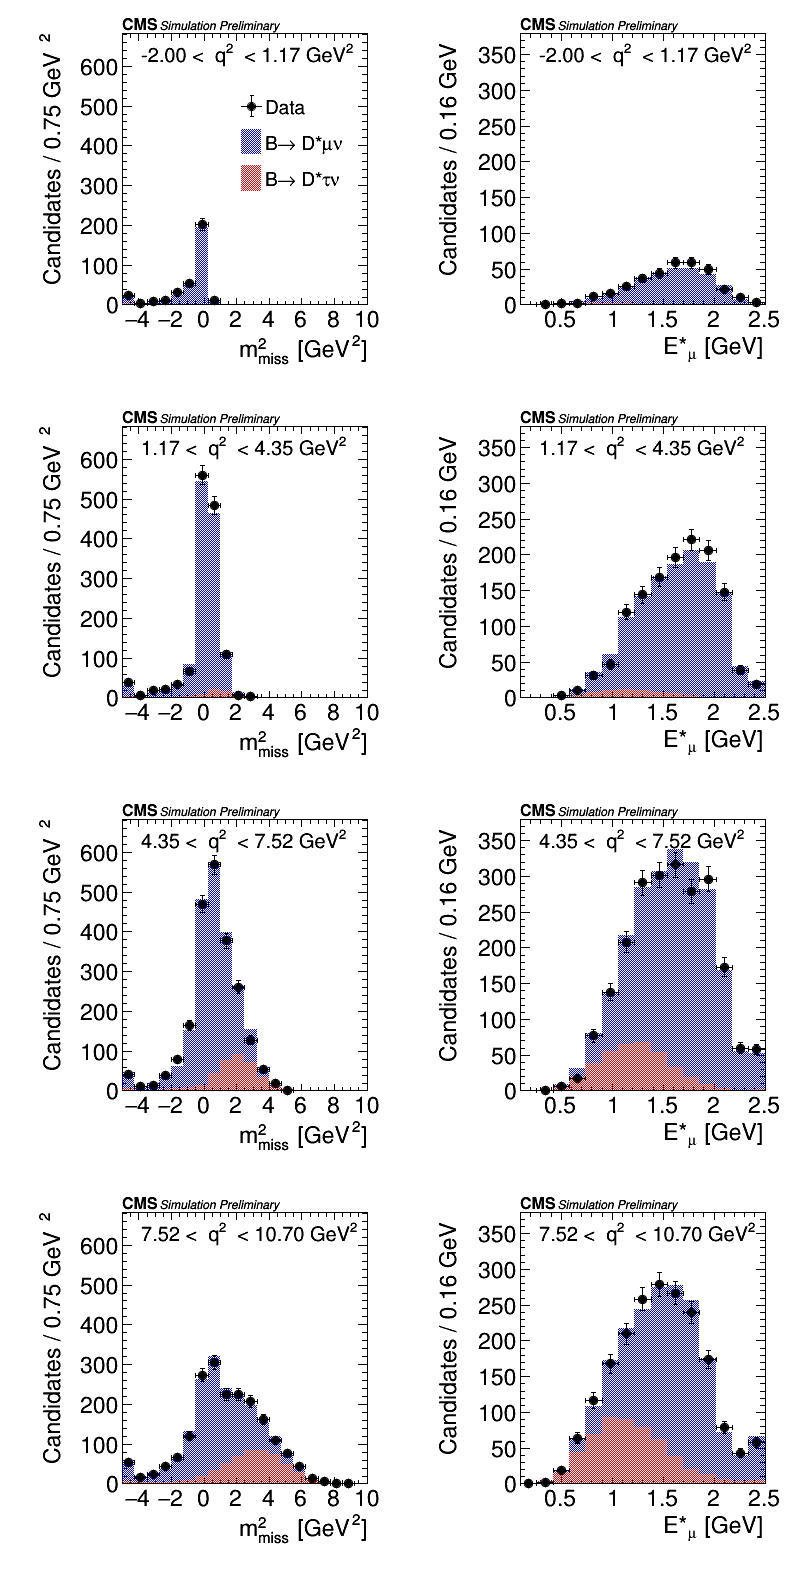

In [72]:
canvas = rt.TCanvas('c_out', 'c_out', 50, 50, 2*400, 400*binning['q2'][0])
canvas.SetTickx(0)
canvas.SetTicky(0)
canvas.Divide(2, binning['q2'][0])

CMS_lumi.extraText = "        Simulation Preliminary"

vars_to_plot = ['M2_miss', 'Est_mu']

xAx_title = {'M2_miss':'m^{2}_{miss} [GeV^{2}]', 'Est_mu':'E*_{#mu} [GeV]'}
label_dic = {'data' : 'Data',
             'mu' : 'B#rightarrow D*#mu#nu',
             'tau' : 'B#rightarrow D*#tau#nu'
            }
scale_dic = {'tau':N_B2mu_inj*rawR_inj, 
             'mu':N_B2mu_inj}

max_entries = dict(zip(vars_to_plot, [0]*len(vars_to_plot)))
for k, h_dic in histo.iteritems():
    if 'M2' in k:
        max_entries['M2_miss'] = max(h_dic['data'].GetMaximum(), max_entries['M2_miss'])
    elif 'Est' in k:
        max_entries['Est_mu'] = max(h_dic['data'].GetMaximum(), max_entries['Est_mu'])

for i_q2 in range(binning['q2'][0]):
    w_q2 = (binning['q2'][2] - binning['q2'][1])/binning['q2'][0]
    q2_l = binning['q2'][1] + w_q2 * i_q2
    q2_h = binning['q2'][1] + w_q2 * (i_q2+1)
    q2_txt = '{:.2f} <  q^{{2}}  < {:.2f} GeV^{{2}}'.format(q2_l, q2_h)

    for i_v, vark in enumerate(vars_to_plot):
        cat_name = vark+'_q2-'+str(i_q2)
        h_dic = histo[cat_name]
        
        h = h_dic['data'].Clone('h_aux_data_'+cat_name)
        h.SetLineColor(1)
        h.SetLineWidth(1)
        h.SetMarkerColor(1)
        h.SetMarkerStyle(20)
        h.GetXaxis().SetTitle(xAx_title[vark])
        h.GetXaxis().SetTitleSize(0.07)
        h.GetXaxis().SetLabelSize(0.07)
        h.GetYaxis().SetTitleOffset(1.7)
        h.GetXaxis().SetTitleOffset(1.1)
        h.GetYaxis().SetTitleSize(0.07)
        h.GetYaxis().SetLabelSize(0.07)
        iunits = xAx_title[vark].find('[') + 1
        h.GetYaxis().SetTitle('Candidates / {:.2f} '.format(h.GetBinWidth(1)) + xAx_title[vark][iunits:-1])
        h.GetYaxis().SetRangeUser(0, max_entries[vark]*1.2)

        h_tau = h_dic['tau'].Clone('h_aux_tau_'+cat_name)
        h_tau.Scale(scale_dic['tau'])
        h_tau.SetLineWidth(0)
        h_tau.SetFillColor(2)
        h_tau.SetFillStyle(3001)
        h_tau.Sumw2(0)
        
        h_mu = h_dic['mu'].Clone('h_aux_mu_'+cat_name)
        h_mu.Scale(scale_dic['mu'])
        h_mu.Add(h_tau)
        h_mu.SetLineWidth(0)
        h_mu.SetFillColor(4)
        h_mu.SetFillStyle(3001) 
        h_mu.Sumw2(0)

        i_pad = i_q2*2 + i_v + 1
        pad = canvas.cd(i_pad)
        pad.SetBottomMargin(0.2)
        pad.SetRightMargin(0.06)
        pad.SetLeftMargin(0.3)

        h.Draw('E1')
        h_mu.Draw('SAME')
        h_tau.Draw('SAME')
        h.Draw('SAMEE1')

        l = rt.TLatex()
        l.SetTextAlign(11)
        l.SetTextSize(0.06)
        l.SetTextFont(42)
        l.DrawLatexNDC(0.35, 0.87, q2_txt)

        CMS_lumi.CMS_lumi(pad, -1, 0, 0.75*1.3, 0.6*1.3)

        if i_pad == 1:
            leg = rt.TLegend(0.6, 0.5, 0.9, 0.8)
            leg.SetTextFont(42)
            leg.SetTextAlign(12)
            leg.SetLineWidth(0)
            leg.SetBorderSize(0)
            leg.AddEntry(h, label_dic['data'], 'lep')
            leg.AddEntry(h_mu, label_dic['mu'], 'f')
            leg.AddEntry(h_tau, label_dic['tau'], 'f')
            leg.Draw()

        donotdelete.append([h, h_tau, h_mu])

canvas.Draw()

# Write the card

In [24]:
sig_processes = ['tau', 'mu']
bkg_processes = []
processes = sig_processes + bkg_processes
categories = np.sort(histo.keys())

In [25]:
card_location = 'cards/{}.txt'.format(card_name)
fc = open(card_location, 'w')

In [26]:
# number of different categories
card = 'imax *\n'
# number of processes minus one
card += 'jmax {}\n'.format(len(processes)-1)
# number of nuissance parameters
card += 'kmax *\n'
card += '-------------------------------\n'

In [27]:
for k in categories:
    card += 'shapes * {} {} $PROCESS $PROCESS__$SYSTEMATIC\n'.format(k, histo_file_loc[k])
card += '-------------------------------\n'

In [28]:
card += 'bin ' + ' '.join(categories) + '\n'
obs = map(lambda k: '{:.0f}'.format(histo[k]['data'].Integral()), categories)
obs = ' '.join(obs)
card += 'observation ' + obs + '\n'
card += '-------------------------------\n'

In [29]:
aux_bin = ''
aux_proc_name = ''
aux_proc_id = ''
aux_proc_rate = ''
for c, p in itertools.product(categories, processes):
    aux_bin += ' '+c
    aux_proc_name += ' '+p
    aux_proc_id += ' '+str(np.argmax(np.array(processes) == p))
    aux_proc_rate += ' {}'.format(histo[c][p].Integral())
    
card += 'bin' + aux_bin + '\n'
card += 'process' + aux_proc_name + '\n'
# Zero or negative for sig and positive for bkg
card += 'process' + aux_proc_id + '\n'
# Expected rate
card += 'rate' + aux_proc_rate + '\n'
card += '-------------------------------\n'

Add additional rate parameters

In [30]:
card += 'N_B2mu rateParam * tau {}\n'.format(N_B2mu_inj)
card += 'N_B2mu rateParam * mu {}\n'.format(N_B2mu_inj)
card += '-------------------------------\n'

MC statistic systematics

In [31]:
card += '* autoMCStats 0 1 1\n'
card += '-------------------------------\n'

In [32]:
print card

imax *
jmax 1
kmax *
-------------------------------
shapes * Est_mu_q2-0 ../data/_root/histos4combine/Cat_q2var_test_Est_mu_q2-0.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * Est_mu_q2-1 ../data/_root/histos4combine/Cat_q2var_test_Est_mu_q2-1.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * Est_mu_q2-2 ../data/_root/histos4combine/Cat_q2var_test_Est_mu_q2-2.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * Est_mu_q2-3 ../data/_root/histos4combine/Cat_q2var_test_Est_mu_q2-3.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * M2_miss_q2-0 ../data/_root/histos4combine/Cat_q2var_test_M2_miss_q2-0.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * M2_miss_q2-1 ../data/_root/histos4combine/Cat_q2var_test_M2_miss_q2-1.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * M2_miss_q2-2 ../data/_root/histos4combine/Cat_q2var_test_M2_miss_q2-2.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * M2_miss_q2-3 ../data/_root/histos4combine/Cat_q2var_test_M2_miss_q2-3.root $PROCESS $PROCESS__$SYSTEMATIC
-------------------------------
bin

In [33]:
fc.write(card)
fc.close()

### Create output directory

In [34]:
outdir = 'results/' + card_name

if os.path.isdir(outdir):
    os.system('rm -rf ' + outdir)
os.system('mkdir ' + outdir);

# Run Combine

### Run the Maximum Likelyhood fit

In [35]:
cmd = 'combine'
cmd += ' -M FitDiagnostics'
cmd += ' --robustFit 1'
cmd += ' --skipBOnlyFit'
cmd += ' -d ' + card_location
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --X-rtd MINIMIZER_analytic'
cmd += ' --setParameters r=0.1'
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' --trackParameters N_B2mu'
cmd += ' -n {}'.format(card_name)
cmd += ' --out ' + outdir
cmd += ' --saveShapes --saveWithUncertainties'
cmd += ' --plots'
cmd += ' --verbose 9'

In [36]:
print cmd
os.system(cmd)
os.system('mv combine_logger.out ' + outdir + '/')
os.system('mv ./*.root ' + outdir + '/')

combine -M FitDiagnostics --robustFit 1 --skipBOnlyFit -d cards/Cat_q2var_test.txt -D dataObs --X-rtd MINIMIZER_analytic --setParameters r=0.1 --setParameterRanges r=0.001,1 --trackParameters N_B2mu -n Cat_q2var_test --out results/Cat_q2var_test --saveShapes --saveWithUncertainties --plots --verbose 9


0


   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is FitDiagnostics
>>> random number generator seed is 123456
Turning on runtime-define MINIMIZER_analytic
import (../data/_root/histos4combine/Cat_q2var_test_Est_mu_q2-0.root,dataObs) -> shapeBkg_dataObs_Est_mu_q2-0

import (../data/_root/histos4combine/Cat_q2var_test_Est_mu_q2-0.root,mu) -> shapeBkg_mu_Est_mu_q2-0

import (../data/_root/histos4combine/Cat_q2var_test_Est_mu_q2-0.root,tau) -> shapeSig_tau_Est_mu_q2-0

import (../data/_root/histos4combine/Cat_q2var_test_Est_mu_q2-1.root,dataObs) -> shapeBkg_dataObs_Est_mu_q2-1

import (../data/_root/histos4combine/Cat_q2var_test_Est_mu_q2-1.root,mu) -> shapeBkg_mu_Est_mu_q2-1

import (../data/_root/histos4combine/Cat_q2var_test_Est_mu_q2-1.root,tau) -> shapeSig_tau_Est_mu_q2-1

import (../data/_root/histos4combine/Cat_q2var_test_Est_mu_q2-2.root,dataObs) -> shapeBkg_dataObs_Est_mu_q2-2

import (../data/_root/

Using shapes: qui si parra' la tua nobilitate
Channel Est_mu_q2-0 has bin 2 fill in data but empty in all backgrounds
Channel Est_mu_q2-3 has bin 1 fill in data but empty in all backgrounds
Channel M2_miss_q2-3 has bin 18 fill in data but empty in all backgrounds
Channel M2_miss_q2-3 has bin 19 fill in data but empty in all backgrounds
Will use binning variable CMS_th1x with 20 bins
Will use category 'CMS_channel' to identify the 8 channels
Creating pdfs for individual modes (8): .    1.    2.    3.    4.    5.    6.    7.    8done.
Importing combined pdf model_s
Setting variable 'MH' in workspace to the higgs mass 120
Missing background ModelConfig 'ModelConfig_bonly' in workspace 'w' in file roostats-sZuqiN.root
Will make one from the signal ModelConfig 'ModelConfig' setting signal strenth 'r' to zero
Error in <RooFormula::Compile>:  Bad numerical expression : "CMS_channel::Est_mu_q2"
Error in <RooFormula::Compile>:  Bad numerical expression : "

In [37]:
f = ur.open(glob(outdir + '/higgsCombine{}.FitDiagnostics.mH120.root'.format(card_name))[0])
c, d, u, _ = f['limit']['limit'].array()
print '{:.3f} +{:.3f}/-{:.3f}'.format(c, u-c, c-d)

0.187 +0.011/-0.011


### Run the Goodness of fit test

Run the observed test stat value

In [39]:
cmd = 'combine'
cmd += ' -M GoodnessOfFit'
cmd += ' -d ' + card_location
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' -n Obs'                                    # Just the output name
cmd += ' -t 0'                                      # Don't run toys
cmd += ' -s -1'                                     # Random seed
cmd += ' --toysNoSystematics --algo=saturated'
# cmd += ' --toysFrequentist'
cmd += ' --X-rtd MINIMIZER_analytic'
cmd += ' --setParameters r=0.1'
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' --trackParameters N_B2mu'
cmd += ' --plots'
cmd += ' --verbose 9'

In [40]:
print cmd
os.system(cmd)

combine -M GoodnessOfFit -d cards/Cat_q2var_test.txt -D dataObs -n Obs -t 0 -s -1 --toysNoSystematics --algo=saturated --X-rtd MINIMIZER_analytic --setParameters r=0.1 --setParameterRanges r=0.001,1 --trackParameters N_B2mu --plots --verbose 9


0


Will use saturated models to compute goodness of fit for a binned likelihood
>>> method used is GoodnessOfFit
>>> Using OpenSSL to get a really random seed 
>>> Used OpenSSL to get a really random seed -284011222
Turning on runtime-define MINIMIZER_analytic
import (../data/_root/histos4combine/Cat_q2var_test_Est_mu_q2-0.root,dataObs) -> shapeBkg_dataObs_Est_mu_q2-0

import (../data/_root/histos4combine/Cat_q2var_test_Est_mu_q2-0.root,mu) -> shapeBkg_mu_Est_mu_q2-0

import (../data/_root/histos4combine/Cat_q2var_test_Est_mu_q2-0.root,tau) -> shapeSig_tau_Est_mu_q2-0

import (../data/_root/histos4combine/Cat_q2var_test_Est_mu_q2-1.root,dataObs) -> shapeBkg_dataObs_Est_mu_q2-1

import (../data/_root/histos4combine/Cat_q2var_test_Est_mu_q2-1.root,mu) -> shapeBkg_mu_Est_mu_q2-1

import (../data/_root/histos4combine/Cat_q2var_test_Est_mu_q2-1.root,tau) -> shapeSig_tau_Est_mu_q2-1

import (../data/_root/histos4combine/Cat_q2var_test_Est_mu_q2-2.root,dataObs) -> shapeBkg_dataObs_Est_mu_q2-2



Using shapes: qui si parra' la tua nobilitate
Channel Est_mu_q2-0 has bin 2 fill in data but empty in all backgrounds
Channel Est_mu_q2-3 has bin 1 fill in data but empty in all backgrounds
Channel M2_miss_q2-3 has bin 18 fill in data but empty in all backgrounds
Channel M2_miss_q2-3 has bin 19 fill in data but empty in all backgrounds
Will use binning variable CMS_th1x with 20 bins
Will use category 'CMS_channel' to identify the 8 channels
Creating pdfs for individual modes (8): .    1.    2.    3.    4.    5.    6.    7.    8done.
Importing combined pdf model_s
Importing combined pdf model_b
Setting variable 'MH' in workspace to the higgs mass 120
RooSimultaneousOpt: number of channel masks must equal number of channels


Run the test stat toy distribution

In [42]:
cmd = 'combine'
cmd += ' -M GoodnessOfFit'
cmd += ' -d ' + card_location
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' -n Toys'                                   # Just the output name
cmd += ' -t 500'                                    # Number of toys to run
cmd += ' -s -1'                                     # Random seed
cmd += ' --toysNoSystematics --algo=saturated'
# cmd += ' --toysFrequentist'
# cmd += '--expectSignal=0'                           # Depending on the hypothesis to test. If none, r is fluctruated
cmd += ' --X-rtd MINIMIZER_analytic'
cmd += ' --setParameters r=0.1'
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' --trackParameters N_B2mu'
cmd += ' --plots'
cmd += ' --verbose 1'

In [43]:
print cmd
os.system(cmd)

combine -M GoodnessOfFit -d cards/Cat_q2var_test.txt -D dataObs -n Toys -t 500 -s -1 --toysNoSystematics --algo=saturated --X-rtd MINIMIZER_analytic --setParameters r=0.1 --setParameterRanges r=0.001,1 --trackParameters N_B2mu --plots --verbose 1


0

 <<< Combine >>> 
Will use saturated models to compute goodness of fit for a binned likelihood
>>> method used is GoodnessOfFit
>>> Using OpenSSL to get a really random seed 
>>> Used OpenSSL to get a really random seed 1241434334
Turning on runtime-define MINIMIZER_analytic
Channel Est_mu_q2-0 will use autoMCStats with settings: event-threshold=0, include-signal=1, hist-mode=1
Analysing bin errors for: prop_binEst_mu_q2-0
Poisson cut-off: 0
Bin        Contents        Error           Notes                         
0          0.000010        0.000000        total sum                     
  => Error is zero, ignore      
------------------------------------------------------------
1          0.696093        0.696088        total sum                     
1          1.000000        1.000000        Unweighted events, alpha=0.696093
  => Total parameter prop_binEst_mu_q2-0_bin1[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
2         

Channel Est_mu_q2-0 has bin 2 fill in data but empty in all backgrounds
Channel Est_mu_q2-3 has bin 1 fill in data but empty in all backgrounds
Channel M2_miss_q2-3 has bin 18 fill in data but empty in all backgrounds
Channel M2_miss_q2-3 has bin 19 fill in data but empty in all backgrounds
RooSimultaneousOpt: number of channel masks must equal number of channels
RooSimultaneousOpt: number of channel masks must equal number of channels
RooSimultaneousOpt: number of channel masks must equal number of channels
RooSimultaneousOpt: number of channel masks must equal number of channels
RooSimultaneousOpt: number of channel masks must equal number of channels
RooSimultaneousOpt: number of channel masks must equal number of channels
RooSimultaneousOpt: number of channel masks must equal number of channels
RooSimultaneousOpt: number of channel masks must equal number of channels
RooSimultaneousOpt: number of channel masks must equal number of channels
RooSimultaneousOpt: number of channel mask

Combine them to get the p-value

In [44]:
name_obs = glob('higgsCombineObs.GoodnessOfFit.*.root')[0]
name_toys = glob('higgsCombineToys.GoodnessOfFit.*.root')[0]

In [45]:
f = ur.open(name_obs)
s_obs = f['limit']['limit'].array()[0]

f = ur.open(name_toys)
s_toys = f['limit']['limit'].array()

p_val = np.sum(s_toys > s_obs)/float(s_toys.shape[0])
print 'p-value: {:.1f}%'.format(100*p_val)

p-value: 78.4%


In [46]:
# cmd = 'combineTool.py'
# cmd += ' -M CollectGoodnessOfFit'
# cmd += ' --mass 120'
# cmd += ' -o gof.json'
# cmd += ' --input {} {}'.format(name_obs, name_toys)
# print cmd
# os.system(cmd)
# os.system('plotGof.py gof.json -o gof --mass 120.0')

In [47]:
os.system('mv *.root {}/'.format(outdir))
os.system('mv *.dot {}/'.format(outdir))
os.system('mv *.out {}/'.format(outdir))

0